In [1]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import gc

In [2]:
file_path = "../uav/DOM_zjsru_ms-5bands_8cm.tif"

with rasterio.open(file_path) as src:
    image_array = src.read()  # shape: (bands, height, width)
    print(image_array.shape)  # (5, H, W) for a 5-band image

(5, 11942, 9338)


# Look at color ortophoto

In [3]:
rgb_array_split = np.clip(image_array[:3].copy(), 0, 1)
for i in range(3): # лучше нормализовать по отдельности
    rgb_array_split[i] = (rgb_array_split[i] - rgb_array_split[i].min()) / (rgb_array_split[i].max() - rgb_array_split[i].min())
rgb_array_split = (rgb_array_split * 255).astype(np.uint8)

In [4]:
if False:
    rgb_image_split = Image.fromarray(np.moveaxis(rgb_array_split, 0, -1)) # from (3, H, W) to (H, W, 3)
    rgb_image_split

In [5]:
# rgb_array_split1 = (rgb_array_split * 2).astype(np.uint8)
# rgb_image_split = Image.fromarray(np.moveaxis(rgb_array_split1, 0, -1)) # from (3, H, W) to (H, W, 3)
# rgb_image_split

In [6]:
# rgb_image_split = Image.fromarray(np.moveaxis(rgb_array_split, 0, -1)) # from (3, H, W) to (H, W, 3)
# rgb_image_split.save("rgb_image_split.jpg")

# Look at NDVI and EVI

In [5]:
ir_bands = np.clip(image_array[3:].copy(), 0, 2) # red edge and nir
for i in range(2):
    ir_bands[i] = (ir_bands[i] - ir_bands[i].min()) / (ir_bands[i].max() - ir_bands[i].min())
ir_bands = (ir_bands * 255).astype(np.uint8)

## NDVI

In [4]:
def compute_ndvi(red: np.ndarray, nir: np.ndarray):
    """
    Compute NDVI while handling division by zero.
    """
    # Convert to float to avoid integer division issues
    red = red.astype(np.float32)  
    nir = nir.astype(np.float32)
    # Compute NDVI safely
    denominator = nir + red
    ndvi = np.where(denominator == 0, -1, (nir - red) / denominator)  # Assign 0 where division is undefined
    
    return ndvi

def ndvi_to_grayscale(ndvi):
    # Normalize NDVI (-1 to 1) to (0 to 255) for grayscale
    ndvi_normalized = ((ndvi + 1) / 2 * 255).astype(np.uint8)  
    return Image.fromarray(ndvi_normalized)

In [6]:
ndvi = compute_ndvi(rgb_array_split[0], ir_bands[1])

C:\Users\Вадим\AppData\Local\Temp\ipykernel_15384\3584187671.py:10: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator == 0, -1, (nir - red) / denominator)  # Assign 0 where division is undefined


In [10]:
# display NDVI
# ndvi_image = ndvi_to_grayscale(ndvi)
# ndvi_image

In [11]:
if False:
    del ndvi_image
    gc.collect()

## EVI

In [7]:
def compute_evi(red: np.ndarray, blue: np.ndarray, nir: np.ndarray, L=1, C1=6, C2=7.5, G=2.5):
    """
    Compute EVI while handling division by zero.
    """
    # Convert to float to avoid integer division issues
    red = red.astype(np.float32) 
    nir = nir.astype(np.float32)
    blue = blue.astype(np.float32)
    # Compute NDVI safely
    denominator = nir + C1 * red - C2 * blue + L
    ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined
    
    return ndvi

def evi_to_grayscale(evi):
    evi = np.clip(evi, -1, 3)  # Clip range
    evi_scaled = ((evi - evi.min()) / (evi.max() - evi.min()) * 255).astype(np.uint8)  # Scale to [0,255]
    return Image.fromarray(evi_scaled)

In [8]:
evi = compute_evi(rgb_array_split[0], rgb_array_split[2], ir_bands[1])

C:\Users\Вадим\AppData\Local\Temp\ipykernel_21404\1157639335.py:11: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined
C:\Users\Вадим\AppData\Local\Temp\ipykernel_21404\1157639335.py:11: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator == 0, 0, G * (nir - red) / denominator)  # Assign 0 where division is undefined


In [9]:
evi_clipped = np.clip(evi, -5, 10)

In [15]:
# display EVI
# evi_image = evi_to_grayscale(evi)
# evi_image

In [16]:
if False:
    del evi_image
    gc.collect()

# Calculate metrics

In [9]:
# Load labeled points
labeled_points = pd.read_csv("labeled_points.csv")

# Convert to integer coordinates for indexing
labeled_points['x'] = labeled_points['x'].astype(int)
labeled_points['y'] = labeled_points['y'].astype(int)

In [18]:
# display evi with matplotlib, make figure size bigger
# plt.figure(figsize=(12, 10))
# plt.imshow(evi_clipped, cmap='viridis')
# plt.colorbar()
# plt.show()

In [10]:
predictions = []

# Ground truth labels: 1 = vegetation, 2 = non-vegetation
# Your prediction: class 1 if NDVI > threshold, else class 2
def compute_error_matrix(index_name, index_threshold=0.5):
    """Returns TP, TN, FP, FN"""
    index = ndvi if index_name == 'ndvi' else evi
    index_mask = index > index_threshold
    tp, tn, fp, fn = 0, 0, 0, 0
    # predictions = []
    for _, row in labeled_points.iterrows():
        x, y, label = row['x'], row['y'], row['label']
        predicted_label = 1 if index_mask[y, x] else 2
        predictions.append(predicted_label)
        if predicted_label == 1:
            if predicted_label == label:
                tp += 1
            else:
                fp += 1
        elif predicted_label == 2:
            if predicted_label == label:
                tn += 1
            else:
                fn += 1
    return tp, tn, fp, fn


def compute_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall !=0 else 0
    return accuracy, precision, recall, f1


def find_best_threshold(index_name='ndvi', return_other_metrics=False):
    index = ndvi if index_name == 'ndvi' else evi_clipped
    lower_bound, upper_bound = 0, index.max().astype(np.int32)
    threshold_values = [lower_bound + i * 0.01 for i in range(upper_bound * 100)]
    accuracy_values = []
    if return_other_metrics:
        precision_values = []
        recall_values = []
        f1_values = []

    for thresh in tqdm(threshold_values):
        accuracy, precision, recall, f1 = compute_metrics(*compute_error_matrix(index_name, thresh))
        accuracy_values.append(accuracy)
        if return_other_metrics:
            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1)
    if return_other_metrics:
        return threshold_values, accuracy_values, precision_values, recall_values, f1_values
    return threshold_values, accuracy_values


def visualize_error_matrix(tp, tn, fp, fn):
    # Create the confusion matrix as a 2x2 array
    confusion_matrix = np.array([[tp, fn],
                                [fp, tn]])

    # Labels for axes
    labels = ['Positive', 'Negative']

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel('Предсказанная метка')
    plt.ylabel('Истинная метка')
    plt.title('Матрица ошибок')
    plt.show()

### Best threshold for NDVI

In [20]:
# threshold_values, accuracy_values, precision_values, recall_values, f1_values = find_best_threshold(index_name='ndvi', return_other_metrics=True)

In [21]:
ndvi_metrics_df = pd.DataFrame({
    'threshold': threshold_values,
    'accuracy': accuracy_values,
    'precision': precision_values,
    'recall': recall_values,
    'f1': f1_values
})

NameError: name 'threshold_values' is not defined

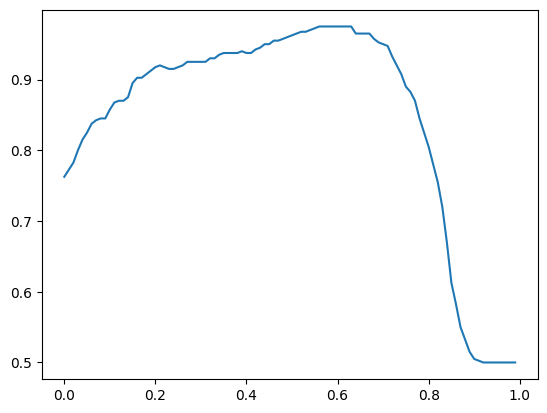

In [ ]:
plt.plot(threshold_values, accuracy_values)

In [ ]:
ndvi_metrics_df[ndvi_metrics_df['accuracy'] == ndvi_metrics_df['accuracy'].max()]

,threshold,accuracy,precision,recall,f1
56,0.56,0.975,0.979798,0.970,0.974874
57,0.57,0.975,0.979798,0.970,0.974874
58,0.58,0.975,0.979798,0.970,0.974874
59,0.59,0.975,0.979798,0.970,0.974874
60,0.60,0.975,0.984694,0.965,0.974747
61,0.61,0.975,0.984694,0.965,0.974747
62,0.62,0.975,0.984694,0.965,0.974747
63,0.63,0.975,0.984694,0.965,0.974747


In [26]:
tp, tn, fp, fn =compute_error_matrix(index_name='ndvi', index_threshold=0.56)
accuracy, precision, recall, f1 = compute_metrics(tp, tn, fp, fn)
print(accuracy, precision, recall)

0.975 0.9797979797979798 0.97


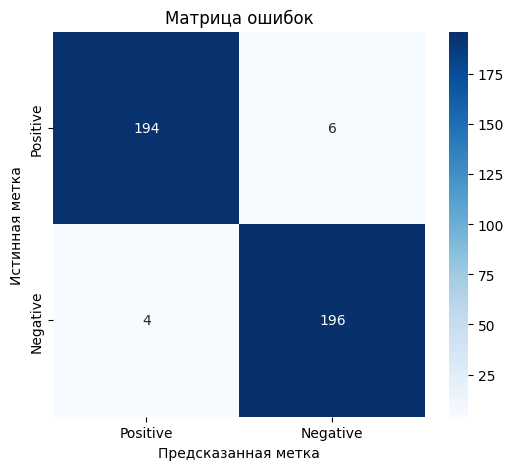

In [ ]:
visualize_error_matrix(tp, tn, fp, fn)

### Best threshold for EVI

In [ ]:
# threshold_values, accuracy_values, precision_values, recall_values, f1_values = find_best_threshold(index_name='evi', return_other_metrics=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
evi_metrics_df = pd.DataFrame({
    'threshold': threshold_values,
    'accuracy': accuracy_values,
    'precision': precision_values,
    'recall': recall_values,
    'f1': f1_values
})

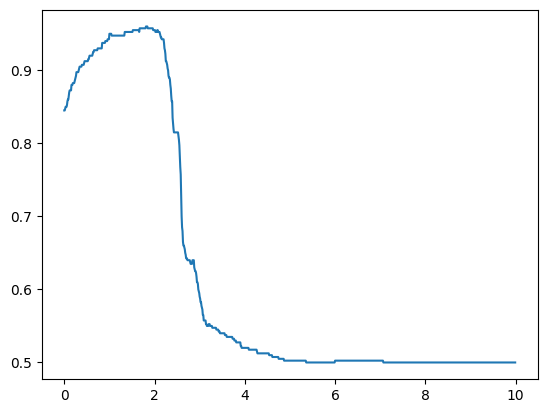

In [ ]:
plt.plot(threshold_values, accuracy_values)

In [ ]:
evi_metrics_df[evi_metrics_df['accuracy'] == evi_metrics_df['accuracy'].max()]

,threshold,accuracy,precision,recall,f1
181,1.81,0.96,0.955446,0.965,0.960199
182,1.82,0.96,0.955446,0.965,0.960199
183,1.83,0.96,0.955446,0.965,0.960199
184,1.84,0.96,0.955446,0.965,0.960199


In [ ]:
tp, tn, fp, fn = compute_error_matrix(index_name='evi', index_threshold=1.81)
accuracy, precision, recall, f1 = compute_metrics(tp, tn, fp, fn)
print(accuracy, precision, recall)

0.96 0.9554455445544554 0.965


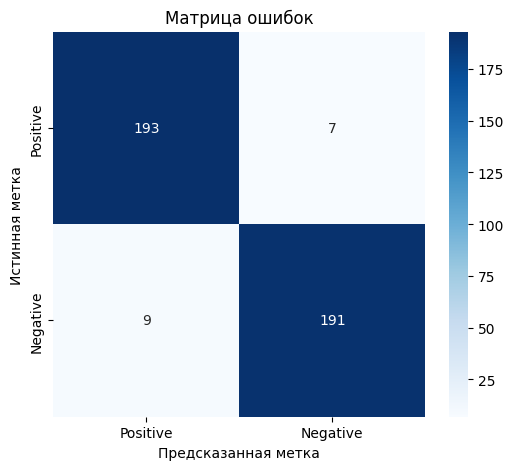

In [ ]:
visualize_error_matrix(tp, tn, fp, fn)

# Visualize predictions

In [11]:
ndvi_mask = ndvi > 0.56

In [45]:
# veg_image_brighter = rgb_array_split * ndvi_mask * 2.2
# veg_image_brighter = (veg_image_brighter).astype(np.uint8)
# Image.fromarray(np.moveaxis(veg_image_brighter, 0, -1))

In [ ]:
# Image.fromarray(np.moveaxis(rgb_array_split * ndvi_mask, 0, -1))

d:\anaconda\envs\course\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (111514396 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


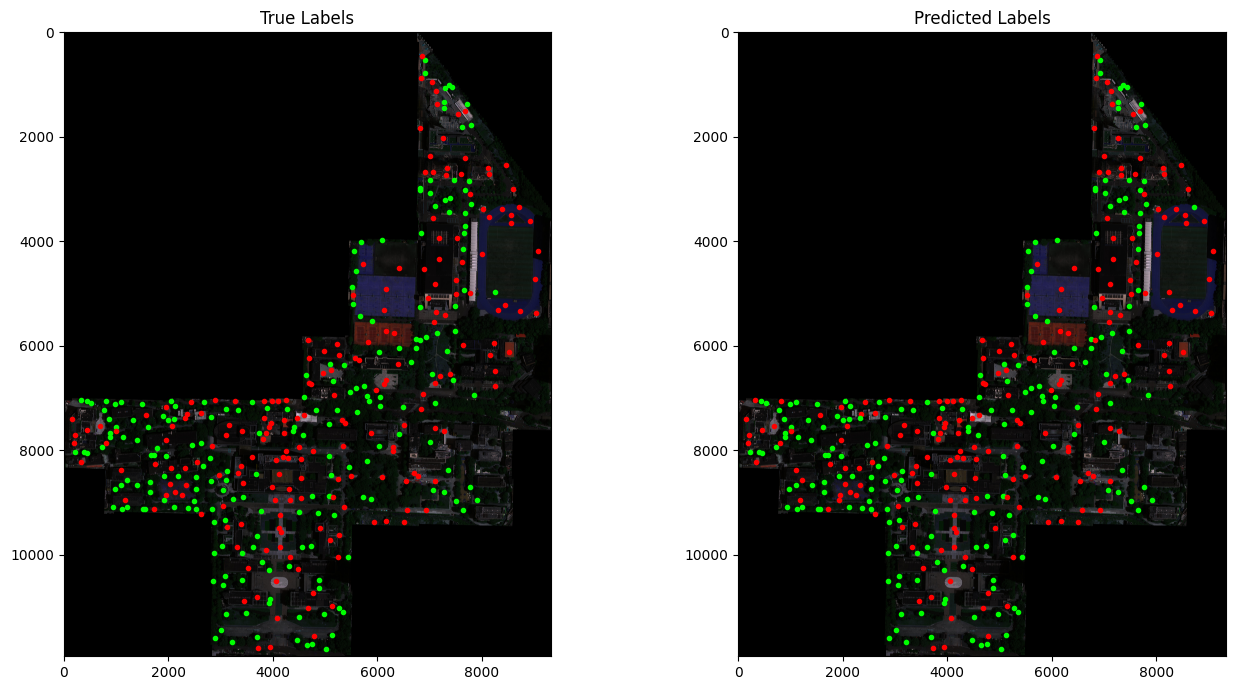

In [29]:
# Load original image
image = plt.imread('rgb_image_split.jpg')

# Load labeled data
df = labeled_points.copy()
coords = df[['x', 'y']].values
true_labels = df['label'].values

# Load or simulate predictions (just as an example: all 1s or threshold NDVI result)
# predictions = your_model_predictions  # replace with your actual prediction array
# For testing, let's simulate:
# predictions = np.random.choice([1, 2], size=len(true_labels))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# True Labels
axes[0].imshow(image)
axes[0].set_title('True Labels')
for (x, y), label in zip(coords, true_labels):
    color = 'lime' if label == 1 else 'red'
    axes[0].plot(x, y, 'o', color=color, markersize=3)

# Predictions
axes[1].imshow(image)
axes[1].set_title('Predicted Labels')
for (x, y), pred in zip(coords, predictions):
    color = 'lime' if pred == 1 else 'red'
    axes[1].plot(x, y, 'o', color=color, markersize=3)

plt.tight_layout()
plt.show()

# Calculate vegetation volume

## Total area

In [8]:
pixel_size = 0.076

In [9]:
rgb_array = image_array[:3].copy()
(rgb_array > -10000).sum() * pixel_size * pixel_size

np.float64(783247.4044)

## Function for volume and area calculation 

In [40]:
height_array_final.min()

np.float32(0.0)

In [49]:
def calculate_volume_area(height_array, index_thresh=0.56):
    ndvi_mask = ndvi > index_thresh
    veg_area = ndvi_mask.sum() * pixel_size * pixel_size
    veg_volume = height_array[ndvi_mask].sum() * pixel_size * pixel_size
    return veg_area, veg_volume

def calculate_co2(veg_volume):
    ro = 600
    m = ro * veg_volume # biomass
    dm = 0.725 * m # dry biomass
    cm = 0.5 * dm # carbon mass
    co2 = 3.67 * cm
    return co2

def form_volume_df(height_array):
    thresh_values = [0.4 + i * 0.05 for i in range(6)]
    co2_values = []
    area_ratios = []
    volume_ratios = []
    area_values = []

    total_volume = height_array.sum() * pixel_size * pixel_size
    total_area = (rgb_array > -10000).sum() * pixel_size * pixel_size

    for thresh in thresh_values:
        veg_area, veg_volume = calculate_volume_area(height_array, thresh)
        area_values.append(veg_area)
        volume_ratios.append(veg_volume / total_volume * 100)
        area_ratios.append(veg_area / total_area * 100)
        co2_values.append(calculate_co2(veg_volume) / 1000)

    volume_df = pd.DataFrame({
        "thresh": thresh_values,
        "co2": co2_values,
        "area_ratio": area_ratios,
        "vol_ratio": volume_ratios,
        "area": area_values
    })

    return volume_df

In [11]:
def visualize_array_1d(input_array):
    array = input_array.copy()
    array = (array - array.min()) / (array.max() - array.min())
    array = (array * 255).astype(np.uint8)
    return Image.fromarray(array)

In [42]:
# visualize height map
file_path = "../uav/DSM_zjsru_op_8cm.tif"

with rasterio.open(file_path) as src:
    height_array = src.read()  # shape: (bands, height, width)
    print(height_array.shape)  # (5, H, W) for a 5-band image

(1, 11942, 9338)


In [43]:
height_array_final = height_array - height_array[height_array > 0].min()
height_array_final = np.clip(height_array_final, 0, height_array_final.max())

## Total volume

In [44]:
height_array_final[0].sum() * pixel_size * pixel_size

np.float32(2626156.5)

# Calculation results

In [ ]:
# visualize_array_1d(height_array_final[0])

In [50]:
volume_df = form_volume_df(height_array_final[0])

In [51]:
volume_df

,thresh,co2,area_ratio,vol_ratio,area
0,0.40,848429.8125,14.738512,40.473431,115439.008928
1,0.45,827519.0625,14.011663,39.475899,109745.986944
2,0.50,803772.1875,13.184738,38.343082,103269.115552
3,0.55,787133.7500,12.635687,37.549366,98968.692944
4,0.60,763222.8125,11.959975,36.408718,93676.196128
5,0.65,741816.4375,11.373060,35.387550,89079.199024


In [52]:
volume_df.index = volume_df["thresh"]
volume_df = volume_df.drop("thresh", axis=1)

In [53]:
volume_df

,co2,area_ratio,vol_ratio,area
thresh,,,,
0.40,848429.8125,14.738512,40.473431,115439.008928
0.45,827519.0625,14.011663,39.475899,109745.986944
0.50,803772.1875,13.184738,38.343082,103269.115552
0.55,787133.7500,12.635687,37.549366,98968.692944
0.60,763222.8125,11.959975,36.408718,93676.196128
0.65,741816.4375,11.373060,35.387550,89079.199024


# Second method

## Current version

In [54]:
def q_co2(ndvi_thresh=0.56):
    W_co2_ref = 0.6
    E = 172
    pixel_size = 0.076
    coef = W_co2_ref * (E / 365) * pixel_size ** 2
    a1, b1, a2, b2 = 0.306, -0.065, -0.534, 0.541
    ndvi_array = np.where(a1 * ndvi + b1 > 0, a1 * ndvi + b1, 1)
    to_sum = -np.log(ndvi_array) * ((1 - 0.5 * ndvi_thresh) + 0.5 * ndvi) / (a2 * ndvi + b2) * (ndvi >= 0.56) * height_array_final[0]
    result = coef * to_sum.sum()
    return result

In [55]:
print(q_co2())

5346297.0


In [58]:
def form_volume_df_second(height_array):
    thresh_values = [0.4 + i * 0.05 for i in range(6)]
    co2_values = []
    area_ratios = []
    volume_ratios = []
    area_values = []

    total_volume = height_array.sum() * pixel_size * pixel_size
    total_area = (rgb_array > -10000).sum() * pixel_size * pixel_size

    for thresh in thresh_values:
        veg_area, veg_volume = calculate_volume_area(height_array, thresh)
        area_values.append(veg_area)
        volume_ratios.append(veg_volume / total_volume * 100)
        area_ratios.append(veg_area / total_area * 100)
        co2_values.append(q_co2(thresh) / 1000)

    volume_df = pd.DataFrame({
        "thresh": thresh_values,
        "co2": co2_values,
        "area_ratio": area_ratios,
        "vol_ratio": volume_ratios,
        "area": area_values
    })

    return volume_df

In [59]:
df = form_volume_df_second(height_array_final[0])

In [60]:
df.index = df["thresh"]
df = df.drop("thresh", axis=1)

In [61]:
df

,co2,area_ratio,vol_ratio,area
thresh,,,,
0.40,5723.950195,14.738512,40.473431,115439.008928
0.45,5605.939941,14.011663,39.475899,109745.986944
0.50,5487.924316,13.184738,38.343082,103269.115552
0.55,5369.895020,12.635687,37.549366,98968.692944
0.60,5251.875488,11.959975,36.408718,93676.196128
0.65,5133.874512,11.373060,35.387550,89079.199024
